In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer 
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, mean_squared_error #roc_auc_score as AUC
from sklearn.externals import joblib

import pickle
import time
import os.path
import math


# Load Data

In [2]:
n_bytes = 2**31
max_bytes = 2**31 - 1

def load_pickle(file_path):
    
    bytes_in = bytearray(0)
    input_size = os.path.getsize(file_path)
    with open(file_path, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    
    return pickle.loads(bytes_in)

In [3]:
train = load_pickle('train_df_after_preprocessing.pkl') # balanced class
valid = load_pickle('valid_df_after_preprocessing.pkl')
test = load_pickle('test_df_after_preprocessing.pkl')

#train_click = train['click']
train_click = train['click']
train_bidprice = train['bidprice']
train_payprice = train['payprice']
#train_X = train.drop(['click', 'bidprice', 'payprice'], axis = 1)
train_X = train.drop(['click', 'bidprice', 'payprice'], axis = 1)

valid_click = valid['click']
valid_bidprice = valid['bidprice']
valid_payprice = valid['payprice']
valid_X = valid.drop(['click', 'bidprice', 'payprice'], axis = 1)

# GBDT+LR

In [18]:
from sklearn import metrics
# 导入数据  
# X = train.drop(['click','payprice','bidprice'], axis = 1) 
# y = train['click']
  
# 切分为测试集和训练集，比例0.5  
X_train, X_test, y_train, y_test = train_test_split(train_X, train_click, test_size=0.5)  
# 将训练集切分为两部分，一部分用于训练GBDT模型，另一部分输入到训练好的GBDT模型生成GBDT特征，然后作为LR的特征。这样分成两部分是为了防止过拟合。  
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)  
  
# 弱分类器的数目  
n_estimator = 60
# 调用GBDT分类模型  
grd = GradientBoostingClassifier(n_estimators=n_estimator)  
  
# 调用one-hot编码。  
grd_enc = OneHotEncoder()  
  
# 调用LR分类模型。  
grd_lm = LogisticRegression()  
  
#使用X_train训练GBDT模型，后面用此模型构造特征  
grd.fit(X_train, y_train)  
  
#直接进行预测，查看AUC得分  
y_pred_grd = grd.predict_proba(X_test)[:, 1]  
fpr_grd, tpr_grd, _ = metrics.roc_curve(y_test, y_pred_grd)  
roc_auc = metrics.auc(fpr_grd, tpr_grd)  
print('predict',roc_auc)  
  
# fit one-hot编码器  
grd_enc.fit(grd.apply(X_train)[:, :, 0])  
  
#使用训练好的GBDT模型构建特征，然后将特征经过one-hot编码作为新的特征输入到LR模型训练。  
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)  
  
# 用训练好的LR模型多X_test做预测  
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]  
  
# 根据预测结果输出  
fpr_grd_lm, tpr_grd_lm, _ = metrics.roc_curve(y_test, y_pred_grd_lm)  
roc_auc = metrics.auc(fpr_grd_lm, tpr_grd_lm)  
print('predict',roc_auc)
  
print("AUC Score :",(metrics.roc_auc_score(y_test, y_pred_grd_lm)))    

y_pred_grd_lm

predict 0.815748967199
predict 0.834330670449
AUC Score : 0.834330670449


array([ 0.99792132,  0.68147177,  0.89975166, ...,  0.08494489,
        0.43784815,  0.43810584])

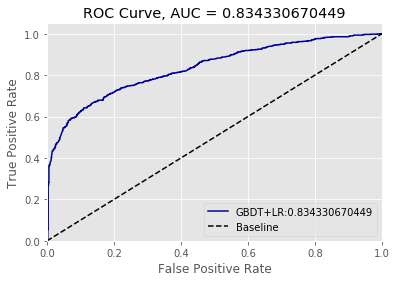

In [19]:
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots()
    ax.plot(fpr_grd_lm, tpr_grd_lm, "#000099", label='GBDT+LR:'+str(roc_auc))
    ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve, AUC = '+str(roc_auc))

In [6]:
joblib.dump(grd_lm, 'GBDT+LR' + ".pickle.dat" )

['GBDT+LR.pickle.dat']

In [7]:
model = joblib.load("GBDT+LR.pickle.dat")
valid_ctr_prediction=model.predict_proba(grd_enc.transform(grd.apply(valid_X)[:, :, 0]))[:, 1]  

# Linear Bidding

In [8]:
def EvaluateClick( bid_price, budget, valid_payprice, valid_click):
    
    auction = bid_price >= valid_payprice
    win_bid_ix = [ index for index,auc in enumerate(auction) if auc ]
    bid_spends = valid_payprice[win_bid_ix].values
    bid_clicks = valid_click[win_bid_ix].values

    budget = 6250000
    current_spend = sum(bid_spends)

    total_bids = len(bid_spends)

    for i in range(len(bid_spends)):

        current_spend -= bid_spends[total_bids-i-1]

        if current_spend <= budget:
            break

    final_win_bid_ix = win_bid_ix[:(total_bids - i -1)]
    bid_spends = sum(valid_payprice[final_win_bid_ix].values)
    bid_clicks = sum(valid_click[final_win_bid_ix].values)
    
    print('clicks:', bid_clicks, 'impressions:', len(final_win_bid_ix), 'spend:', bid_spends)

    return bid_clicks

clicks: 124 impressions: 113890 spend: 4238412
clicks: 128 impressions: 115573 spend: 4353705
clicks: 129 impressions: 117022 spend: 4449767
clicks: 129 impressions: 118561 spend: 4554418
clicks: 131 impressions: 120213 spend: 4661402
clicks: 132 impressions: 122248 spend: 4801753
clicks: 132 impressions: 123616 spend: 4894208
clicks: 132 impressions: 125423 spend: 5024289
clicks: 132 impressions: 127009 spend: 5137885
clicks: 135 impressions: 128572 spend: 5247685
clicks: 138 impressions: 130047 spend: 5352196
clicks: 140 impressions: 131496 spend: 5455551
clicks: 143 impressions: 133026 spend: 5565766
clicks: 143 impressions: 134514 spend: 5677232
clicks: 146 impressions: 136109 spend: 5800321
clicks: 146 impressions: 137480 spend: 5905947
clicks: 147 impressions: 139107 spend: 6029176
clicks: 147 impressions: 140695 spend: 6152755
clicks: 146 impressions: 141702 spend: 6249998
clicks: 145 impressions: 140865 spend: 6249959
clicks: 143 impressions: 139781 spend: 6249974
clicks: 137 i

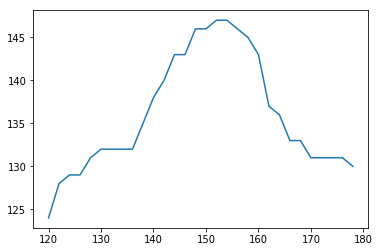

In [9]:
# search the best base_price
base_prices = np.arange(120,180,2)
clicks = []
budget = 6250000
avgCTR=0.738

for base in base_prices:
    
    valid_pctr = valid_ctr_prediction
    bid_price = [ int(base*pCTR/avgCTR) for pCTR in valid_pctr ]
    c = EvaluateClick( bid_price, budget, valid_payprice, valid_click);
    clicks.append(c)

    
plt.figure()
plt.plot(base_prices, clicks)
print('best constant:', base_prices[clicks.index(max(clicks))])

In [20]:
base = base_prices[clicks.index(max(clicks))]

bid_price = [ int(base*pCTR/avgCTR) for pCTR in valid_pctr ]
EvaluateClick( bid_price, budget , valid_payprice, valid_click)

clicks: 147 impressions: 139107 spend: 6029176


147

In [11]:
### prediction
base = base_prices[clicks.index(max(clicks))]

test_prediction = model.predict_proba(grd_enc.transform(grd.apply(test)[:, :, 0]))[:, 1]  
bid_price = [ int(base*pCTR/avgCTR) for pCTR in test_prediction ]

submission = pd.read_csv('Group_xx.csv')
submission['bidprice'] = bid_price
submission.to_csv('GBDT+LR_with_Linear.csv')